In [1]:
%%html

<style>    
    @import url("css/custom_styles.css")
</style>

# Dataset
[Plant Village](https://data.mendeley.com/datasets/tywbtsjrjv/1)

## Description

Dans cette base de données, il y a 39 differentes classes d'image de feuilles. La base de donnée contient 61,486 images.

Les classes sont: 

<br>

<div class="columns_2">
    
1. Apple_scab
2. Apple_black_rot
3. Apple_cedar_apple_rust
4. Apple_healthy
5. Background_without_leaves
6. Blueberry_healthy
7. Cherry_powdery_mildew
8. Cherry_healthy
9. Corn_gray_leaf_spot
10. Corn_common_rust
11. Corn_northern_leaf_blight
12. Corn_healthy
13. Grape_black_rot
14. Grape_black_measles
15. Grape_leaf_blight
16. Grape_healthy
17. Orange_haunglongbing
18. Peach_bacterial_spot
19. Peach_healthy
20. Pepper_bacterial_spot

</div>

<div class="columns_2">
    
21. Pepper_healthy
22. Potato_early_blight
23. Potato_healthy
24. Potato_late_blight
25. Raspberry_healthy
26. Soybean_healthy
27. Squash_powdery_mildew
28. Strawberry_healthy
29. Strawberry_leaf_scorch
30. Tomato_bacterial_spot
31. Tomato_early_blight
32. Tomato_healthy
33. Tomato_late_blight
34. Tomato_leaf_mold
35. Tomato_septoria_leaf_spot
36. Tomato_spider_mites_two-spotted_spider_mite
37. Tomato_target_spot
38. Tomato_mosaic_virus
39. Tomato_yellow_leaf_curl_virus
    
</div>

In [2]:
%matplotlib inline

#
# import utilitaires
#
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from helpers.jupyter import display_html

In [3]:

# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
with hlp.Profile() as load_profile:
    pv_dataset = pv.load(configs.plant_village)
    pv_dataframe = pv_dataset.dataframe
    
print(f"Loading dataset:", load_profile.round_duration(), "s")

Loading dataset: 0.57 s


# asdf

# Exploration

In [4]:
display_html(f"<b>{configs.plant_village.install_path}</b> - data {pv_dataframe.shape}")
display(pv_dataframe.head(5))

species                          disease  \
0  Tomato    Tomato_Yellow_Leaf_Curl_Virus   
1  Orange  Haunglongbing_(Citrus_greening)   
2   Grape             Esca_(Black_Measles)   
3  Tomato    Tomato_Yellow_Leaf_Curl_Virus   
4  Tomato                   Bacterial_spot   

                                    label  \
0           Tomato_Yellow_Leaf_Curl_Virus   
1  Orange_Haunglongbing_(Citrus_greening)   
2              Grape_Esca_(Black_Measles)   
3           Tomato_Yellow_Leaf_Curl_Virus   
4                   Tomato_Bacterial_spot   

                                          image_path  
0  Plant_leave_diseases_dataset_with_augmentation...  
1  Plant_leave_diseases_dataset_with_augmentation...  
2  Plant_leave_diseases_dataset_with_augmentation...  
3  Plant_leave_diseases_dataset_with_augmentation...  
4  Plant_leave_diseases_dataset_with_augmentation...

In [5]:
display_html(f"<b>{configs.plant_village.install_path}</b> - info")
pv_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60343 entries, 0 to 60342
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   species     60343 non-null  object
 1   disease     60343 non-null  object
 2   label       60343 non-null  object
 3   image_path  60343 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [6]:
species = pv_dataframe["species"].unique()
species.sort()
display_html(f"<b>Modalites de 'species'</b> - count: {species.size}")
display(list(species))

['Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

In [7]:
labels = pv_dataframe["label"].unique()
labels.sort()
display_html(f"<b>Modalites de 'label'</b> - count: {len(labels)}")
display(list(labels))

['Apple_Black_rot',
 'Apple_Cedar_apple_rust',
 'Apple_healthy',
 'Apple_scab',
 'Blueberry_healthy',
 'Cherry_Powdery_mildew',
 'Cherry_healthy',
 'Corn_Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_Common_rust',
 'Corn_Northern_Leaf_Blight',
 'Corn_healthy',
 'Grape_Black_rot',
 'Grape_Esca_(Black_Measles)',
 'Grape_Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape_healthy',
 'Orange_Haunglongbing_(Citrus_greening)',
 'Peach_Bacterial_spot',
 'Peach_healthy',
 'Pepper,_bell_Bacterial_spot',
 'Pepper,_bell_healthy',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Potato_healthy',
 'Raspberry_healthy',
 'Soybean_healthy',
 'Squash_Powdery_mildew',
 'Strawberry_Leaf_scorch',
 'Strawberry_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites Two-spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_healthy',
 'Tomato_mosaic_virus']

<font class="answer">

**Notes**
* Background_without_leaves a été intentionellement enlevé
* Les modalités semblent avoir evoluées par rapport à la liste citée ci-haut

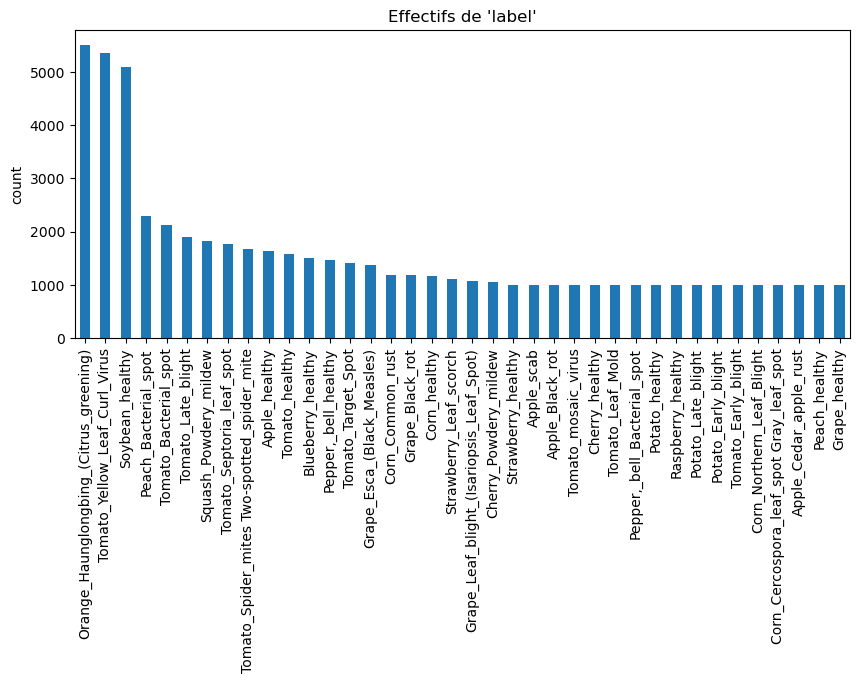

In [8]:
#
# distribution de label
#
FIGSIZE = (10, 4)

disease_count = pv_dataframe["label"].value_counts()
disease_count.sort_values(inplace=True, ascending=False)

plt.figure(figsize=FIGSIZE)
disease_count.plot.bar(title="Effectifs de 'label'",
                       ylabel="count")
plt.show()

In [9]:
# Verification des valeurs manquantes

display(pv_dataframe[pv_dataframe.isna().any(
    axis=1)].style.highlight_null('green'))


In [10]:
#
# relation species/label
#
doi = pv_dataframe[["label", "species"]]

disease_samples_per_species = doi.groupby("species").count()
disease_samples_per_species.sort_values("label", inplace=True, ascending=False)

In [11]:
healthy_crit = doi["label"].str.contains("healthy")

healthy = doi[healthy_crit]
healthy = healthy \
            .groupby("species") \
            .count() \
            .rename(columns={"label": "healthy"})

not_healthy = doi[ ~healthy_crit ]
not_healthy = not_healthy \
                .groupby("species") \
                .count() \
                .rename(columns={"label": "autres"})

healthy_vs_other_per_species = pd.merge(healthy, 
                                        not_healthy,
                                        how="outer",
                                        on="species")

# pour faciliter la comparison, garder le meme ordre que disease_samples_per_species
healthy_vs_other_per_species = healthy_vs_other_per_species \
                                   .reindex(disease_samples_per_species \
                                   .index.to_list())

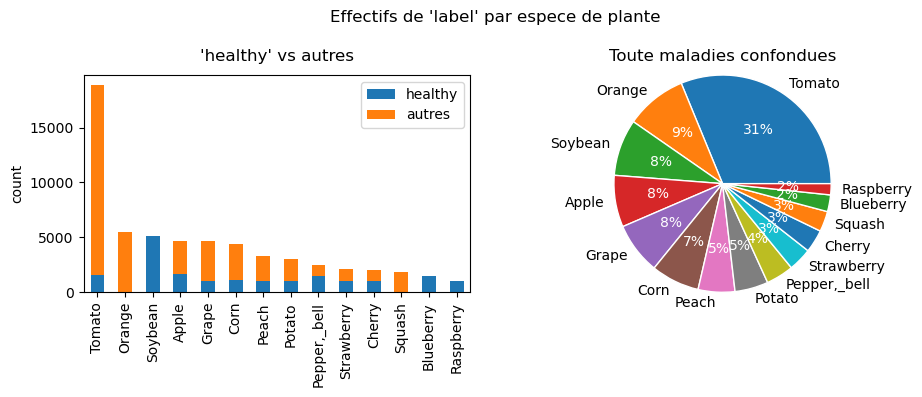

In [12]:
fig = plt.figure(figsize=FIGSIZE)
fig.suptitle("Effectifs de 'label' par espece de plante")

plt.subplot(121)
healthy_vs_other_per_species.plot.bar(ax=plt.gca(),
                                      stacked=True, 
                                      xlabel="",
                                      ylabel="count")
plt.title("'healthy' vs autres", y=1.025)

plt.subplot(122)
_, _, pcts = plt.pie(x=disease_samples_per_species.values.flatten(),
                     labels=disease_samples_per_species.index.values,
                     autopct='%.0f%%',
                     radius=1.25,
                     wedgeprops={'linewidth': 1.0, 
                                 'edgecolor': 'white'})
plt.title("Toute maladies confondues", y=1.025)
plt.setp(pcts, color='white')

plt.tight_layout()
plt.show()

In [13]:
#
# visualiser quelques images
#
SAMPLES_GRID = (2, 7)

# selectionner quelques images aleatoirement (mais pas trop aleatoire)
random.seed(42)
sample_indices = random.sample(range(pv_dataframe.shape[0]), 
                               SAMPLES_GRID[0] * SAMPLES_GRID[1])
sample_indices.sort()

samples = pv_dataframe.iloc[sample_indices]

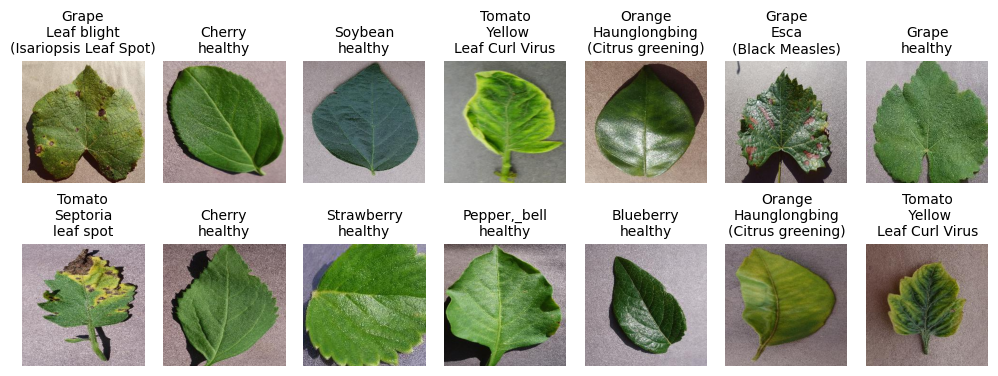

In [14]:
# FIGSIZE = (10, 6.5)

fig = plt.figure(figsize=FIGSIZE)

for i, (sample_index, sample_data) in enumerate(samples.iterrows()):
    plt.subplot(SAMPLES_GRID[0], SAMPLES_GRID[1], i + 1)
    plt.axis("off")

    species = sample_data['species']
    disease = pv.attribute_prettify(species, sample_data['disease'])
        
    image = pv_dataset.get_image(sample_index)
    
    plt.title(f"{species}\n{disease}")    
    plt.imshow(image)
    plt.gca().title.set_size(10)

plt.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.8)
plt.show()

In [15]:
#Exploration des species
df = pv_dataset.dataframe[["label", "species"]]

nbEspece = df.groupby("species").count()
print("Nombres d'individus dans chaque 'species'",nbEspece)


Nombres d'individus dans chaque 'species'               label
species            
Apple          4645
Blueberry      1502
Cherry         2052
Corn           4354
Grape          4639
Orange         5507
Peach          3297
Pepper,_bell   2478
Potato         3000
Raspberry      1000
Soybean        5090
Squash         1835
Strawberry     2109
Tomato        18835


In [16]:
healthy_crit = df["label"].str.contains("healthy")
healthy = df[healthy_crit]
healthy = healthy.groupby("species").count()

not_healthy = df[~healthy_crit]
not_healthy = not_healthy.groupby("species").count()
print("Nombre d'individus dans les 'species' Healthy:\n",healthy)
print("Nombre d'individus dans les 'species' qui sont des maladies:\n",not_healthy)

Nombre d'individus dans les 'species' Healthy:
               label
species            
Apple          1645
Blueberry      1502
Cherry         1000
Corn           1162
Grape          1000
Peach          1000
Pepper,_bell   1478
Potato         1000
Raspberry      1000
Soybean        5090
Strawberry     1000
Tomato         1591
Nombre d'individus dans les 'species' qui sont des maladies:
               label
species            
Apple          3000
Cherry         1052
Corn           3192
Grape          3639
Orange         5507
Peach          2297
Pepper,_bell   1000
Potato         2000
Squash         1835
Strawberry     1109
Tomato        17244


Nous avons effectué une première sélection en enlevant les species qui ne sont pas représenté dans les deux catégories (healthy et not healthy). Blueberry, Soybean, Rasberry, Squash et Orange ont été enlevé.

In [17]:
def group_selection(df, searchfor):
    crit = '|'.join(searchfor)
    return df[df["label"].str.contains(crit)]


In [18]:
df1 = pv_dataset.dataframe

searchfor = ["Apple", "Cherry", "Corn", "Grape", "Peach",
             "Pepper,_bell", "Potato", "Strawberry", "Tomato"]
group_sel = group_selection(df1, searchfor)
# in
sel1 = group_sel.groupby("species").count()

print("Species restant dans la première sélection avec leur effectifs\n", sel1)


Species restant dans la première sélection avec leur effectifs
               disease  label  image_path
species                                 
Apple            4645   4645        4645
Cherry           2052   2052        2052
Corn             4354   4354        4354
Grape            4639   4639        4639
Peach            3297   3297        3297
Pepper,_bell     2478   2478        2478
Potato           3000   3000        3000
Strawberry       2109   2109        2109
Tomato          18835  18835       18835


In [19]:
#Exploration des effectifs de chaque species
def composante(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]

    fruit_count = fruit1["label"].value_counts()
    fruit_count.sort_values

    print("Les composantes de", fruit, "sont :\n", fruit_count)


In [20]:
composante(df, "Tomato")

Les composantes de Tomato sont :
 Tomato_Yellow_Leaf_Curl_Virus                  5357
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites Two-spotted_spider_mite    1676
Tomato_healthy                                 1591
Tomato_Target_Spot                             1404
Tomato_mosaic_virus                            1000
Tomato_Early_blight                            1000
Tomato_Leaf_Mold                               1000
Name: label, dtype: int64


In [21]:
composante(df, "Apple")


Les composantes de Apple sont :
 Apple_healthy             1645
Apple_Black_rot           1000
Apple_scab                1000
Apple_Cedar_apple_rust    1000
Name: label, dtype: int64


In [22]:
composante(df, "Cherry")


Les composantes de Cherry sont :
 Cherry_Powdery_mildew    1052
Cherry_healthy           1000
Name: label, dtype: int64


In [23]:
composante(df, "Corn")

Les composantes de Corn sont :
 Corn_Common_rust                            1192
Corn_healthy                                1162
Corn_Northern_Leaf_Blight                   1000
Corn_Cercospora_leaf_spot Gray_leaf_spot    1000
Name: label, dtype: int64


In [24]:
composante(df, "Grape")

Les composantes de Grape sont :
 Grape_Esca_(Black_Measles)                  1383
Grape_Black_rot                             1180
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    1076
Grape_healthy                               1000
Name: label, dtype: int64


In [25]:
composante(df, "Peach")

Les composantes de Peach sont :
 Peach_Bacterial_spot    2297
Peach_healthy           1000
Name: label, dtype: int64


In [26]:
composante(df, "Pepper,_bell")

Les composantes de Pepper,_bell sont :
 Pepper,_bell_healthy           1478
Pepper,_bell_Bacterial_spot    1000
Name: label, dtype: int64


In [27]:
composante(df, "Potato")

Les composantes de Potato sont :
 Potato_Early_blight    1000
Potato_Late_blight     1000
Potato_healthy         1000
Name: label, dtype: int64


In [28]:
composante(df, "Strawberry")

Les composantes de Strawberry sont :
 Strawberry_Leaf_scorch    1109
Strawberry_healthy        1000
Name: label, dtype: int64


Comme nous avons une grosse base de données nous avons décidé, pour réduire le temps d'exécution et rendre le travail plus facile, de choisir une seule species qui contient plus qu'une maladie et des groupes assez équilibré et des images significatives. Nous allons donc choisir entre Apple, Corn, Grape et Potato. Pour éclairer notre choix nous allons regarder les photos de plus près. 

In [29]:
def affichage_image(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]
    SAMPLES_GRID = (5, 5)

    random.seed(42)
    sample_indices = random.sample(range(fruit1.shape[0]),
                                   SAMPLES_GRID[0] * SAMPLES_GRID[1])
    sample_indices.sort()

    samples = fruit1.iloc[sample_indices]

    FIGSIZE = (10, 10)

    fig = plt.figure(figsize=FIGSIZE)

    for i, (sample_index, sample_data) in enumerate(samples.iterrows()):
        plt.subplot(SAMPLES_GRID[0], SAMPLES_GRID[1], i + 1)
        plt.axis("off")

        species = sample_data['species']
        disease = pv.attribute_prettify(species, sample_data['label'])

        image = pv_dataset.get_image(sample_index)

        plt.title(f"{species}\n{disease}")
        plt.imshow(image)
        plt.gca().title.set_size(10)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.8)
    plt.show()


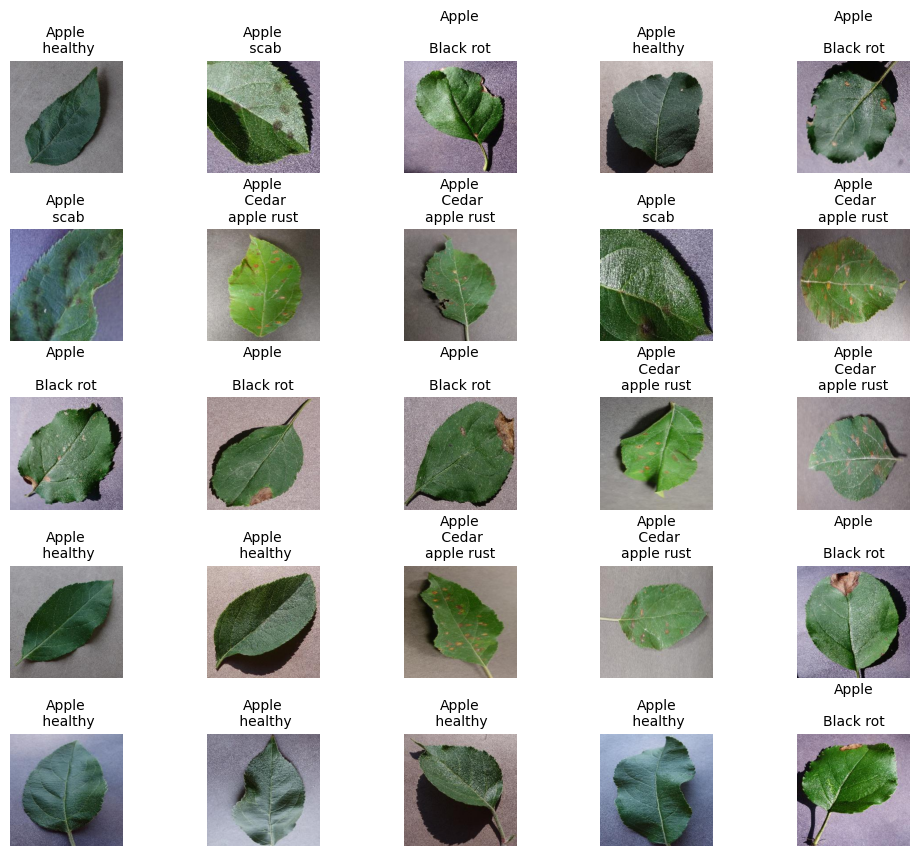

In [30]:
affichage_image(df, "Apple")

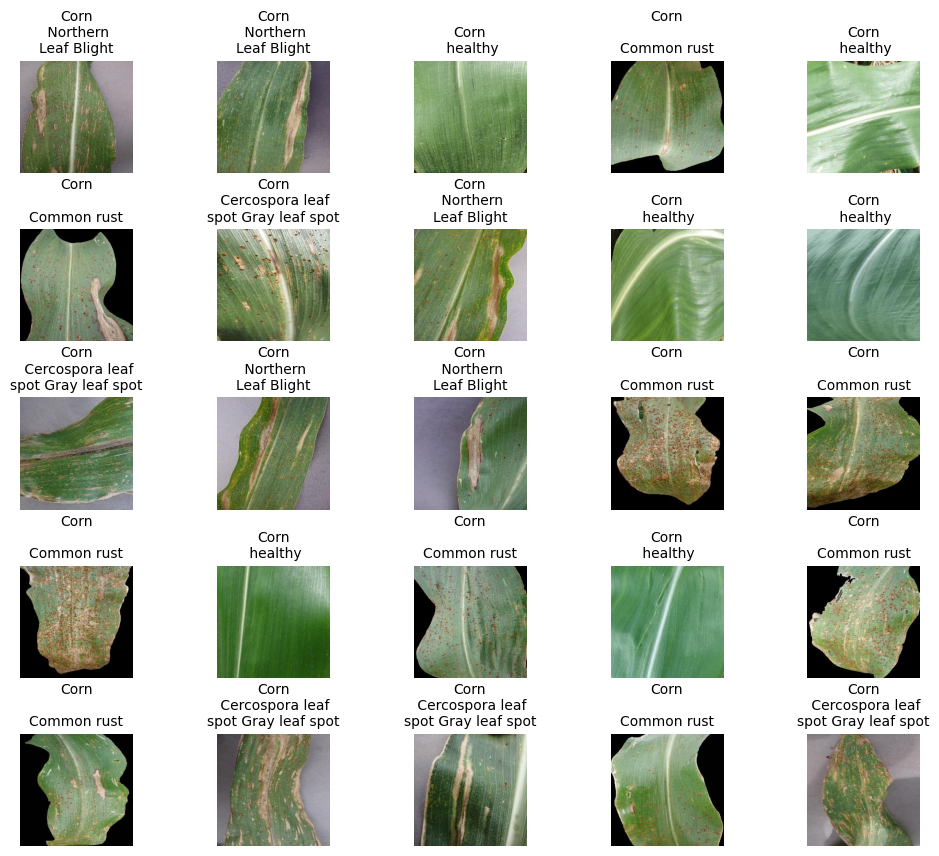

In [31]:
affichage_image(df, "Corn")

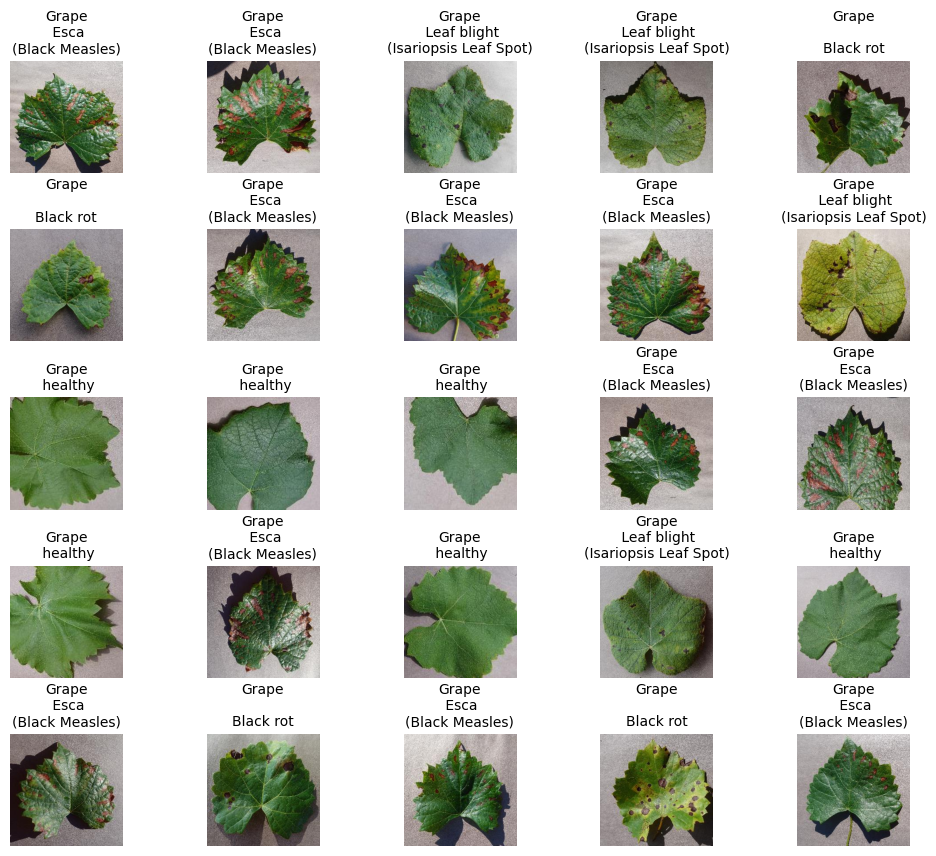

In [32]:
affichage_image(df, "Grape")

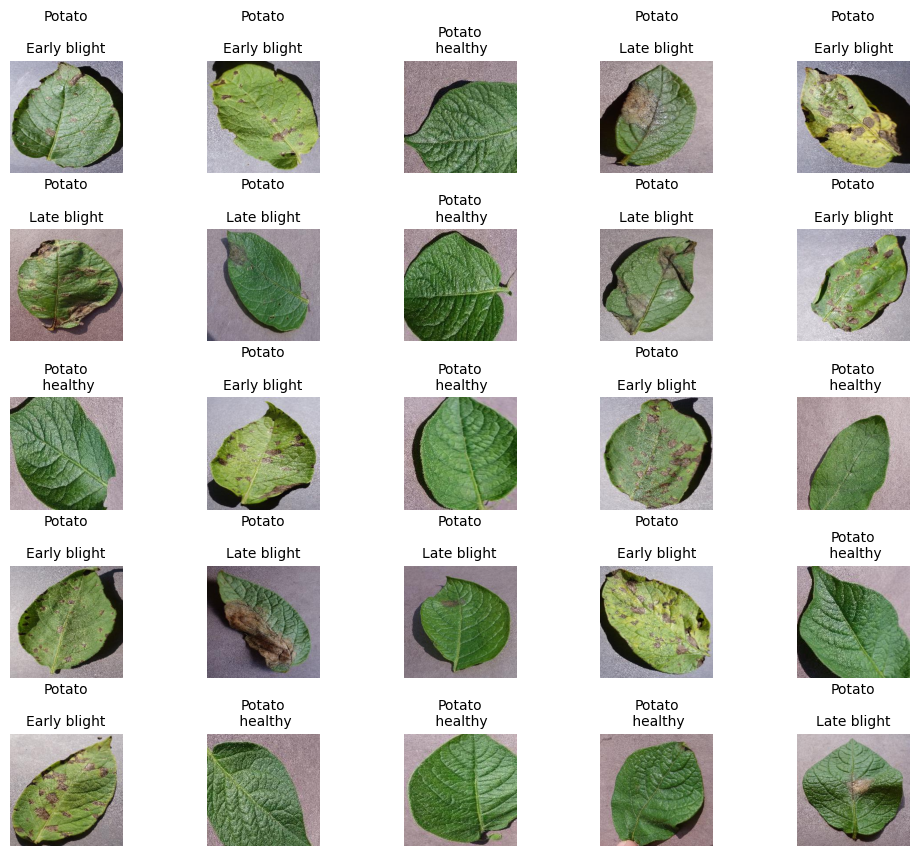

In [33]:
affichage_image(df, "Potato")

En regardant les photos de plus près nous avons constaté que pour les species Apple,Corn et Potato les différences entre les photos des différentes maladies sont moins significatives que pour Grape c'est pourquoi nous avons choisi de garder celle-ci. 

In [34]:
searchfor = ["Grape"]
group_sel = group_selection(df1, searchfor)


In [35]:
#Équilibrage des groupes de Grape

x1 = group_sel
y1 = group_sel["label"].values.reshape(-1, 1)


rus = RandomUnderSampler(random_state=42)
x_bal, y_bal = rus.fit_resample(x1, y1)

x = x_bal["label"]

print(x_bal["label"].value_counts())


Grape_Black_rot                             1000
Grape_Esca_(Black_Measles)                  1000
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    1000
Grape_healthy                               1000
Name: label, dtype: int64


In [36]:
# Préparation de deux ensembles train/test pour le reste des étapes
x_train, x_test = train_test_split(
    x,  stratify=x, test_size=0.2, random_state=44)

x_train = x_train.index.to_list()
x_test = x_test.index.to_list()
split.save(configs.split, x_train, x_test)